In [1]:
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import os
from itertools import cycle


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, Activation, LeakyReLU
LeakyReLU = LeakyReLU(0.1)
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# from scikeras.wrappers import KerasClassifier
from tensorflow.keras.utils import to_categorical, set_random_seed

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, classification_report, RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import RobustScaler, LabelEncoder

import optuna

In [2]:
pwd = os.getcwd()
pwd

'c:\\Users\\abdul\\Desktop\\HEA_2'

In [3]:
df = pd.read_csv(pwd+"/raw_dataset/HEA_tr_NETCORE.csv")
print("Shape of Dataframe: ", df.shape)
df.head()

Shape of Dataframe:  (1167, 44)


,Alloy,avg_dev_AtomicWeight,maximum_MeltingT,avg_dev_MeltingT,mode_MeltingT,avg_dev_Column,mean_Row,mode_Row,minimum_CovalentRadius,maximum_CovalentRadius,range_CovalentRadius,avg_dev_CovalentRadius,mode_CovalentRadius,maximum_Electronegativity,mean_Electronegativity,mode_Electronegativity,mean_NsValence,maximum_NpValence,mean_NpValence,avg_dev_NpValence,range_NdValence,mean_NdValence,avg_dev_NdValence,avg_dev_NValence,mode_NValence,maximum_NdUnfilled,range_NdUnfilled,avg_dev_NdUnfilled,mode_NUnfilled,minimum_GSvolume_pa,range_GSvolume_pa,mode_GSvolume_pa,maximum_GSbandgap,avg_dev_GSbandgap,range_GSmagmom,minimum_SpaceGroupNumber,maximum_SpaceGroupNumber,mean_SpaceGroupNumber,range_Column,maximum_NpUnfilled,maximum_NdValence,mode_MendeleevNumber,range_NUnfilled,Phase
0,Al0.5NbTaTiV,3.838070,3290.0,584.546173,7.571474,0.966843,4.555556,4,121,170,3.912023,2.391138,153,1.63,1.572222,0.916291,1.777778,0.693147,0.111111,0.180262,4,2.666667,0.635989,1.797913,1.609438,8,8,0.908856,7,2.639771,1.819699,2.639771,0.0,0.0,0.000023,194,229,220.777778,9,5,4,43,3,BCC
1,Al0.75MoNbTiV,3.255577,2896.0,521.067701,7.571474,1.140210,4.263158,4,121,164,3.784190,2.377029,153,2.16,1.713158,0.932164,1.578947,0.693147,0.157895,0.235805,5,2.947368,0.845714,0.598806,1.609438,8,8,1.074312,6,2.639771,1.819699,2.639771,0.0,0.0,0.000023,194,229,221.000000,9,5,5,43,3,BCC
2,Al0.25MoNbTiV,3.205911,2896.0,441.662561,7.571474,0.758442,4.411765,4,121,164,3.784190,1.950841,153,2.16,1.725294,0.932164,1.529412,0.693147,0.058824,0.105014,5,3.294118,0.758442,0.492669,1.609438,8,8,0.833360,6,2.639771,1.819699,2.639771,0.0,0.0,0.000023,194,229,220.529412,9,5,5,43,3,BCC
3,Al0.25NbTaTiV,3.825406,3290.0,539.821730,7.571474,0.648931,4.647059,4,121,170,3.912023,2.140270,153,1.63,1.570000,0.916291,1.764706,0.693147,0.058824,0.105014,4,2.823529,0.542163,1.825219,1.609438,8,8,0.718768,7,2.639771,1.819699,2.639771,0.0,0.0,0.000023,194,229,220.529412,9,5,4,43,3,BCC
4,Al0.2MoTaTiV,3.838178,3290.0,565.511565,7.571474,0.703300,4.666667,4,121,170,3.912023,2.105461,153,2.16,1.702857,0.916291,1.761905,0.693147,0.047619,0.086822,5,3.095238,0.645547,1.812332,1.609438,8,8,0.829650,6,2.639771,1.809927,2.639771,0.0,0.0,0.000023,194,229,220.476191,9,5,5,43,3,BCC


In [4]:
# SHUFFLE THE DATASET
df = df.sample(frac=1, random_state=42)
X = df.copy().drop(columns=["Alloy", "Phase"])
y = df["Phase"].astype("category")
print(f"Shape of feature: {X.shape}\nShape of labels: {y.shape}")

Shape of feature: (1167, 42)
Shape of labels: (1167,)


In [5]:
# check class imbalance
print(y.value_counts(ascending=False))

Phase
MIP        428
BCC        363
FCC        211
FCC_BCC    165
Name: count, dtype: int64


In [6]:
from imblearn.over_sampling import SMOTE
X, y = SMOTE(random_state=42).fit_resample(X, y)
print(f"Shape of feature: {X.shape}\nShape of labels: {y.shape}")

Shape of feature: (1712, 42)
Shape of labels: (1712,)


In [7]:
# check for class imbalance
print(y.value_counts(ascending=False))

Phase
BCC        428
FCC        428
FCC_BCC    428
MIP        428
Name: count, dtype: int64


In [8]:
# SCALE FEATURES
X = pd.DataFrame(RobustScaler().fit_transform(X), columns=X.columns)
X.head()

,avg_dev_AtomicWeight,maximum_MeltingT,avg_dev_MeltingT,mode_MeltingT,avg_dev_Column,mean_Row,mode_Row,minimum_CovalentRadius,maximum_CovalentRadius,range_CovalentRadius,avg_dev_CovalentRadius,mode_CovalentRadius,maximum_Electronegativity,mean_Electronegativity,mode_Electronegativity,mean_NsValence,maximum_NpValence,mean_NpValence,avg_dev_NpValence,range_NdValence,mean_NdValence,avg_dev_NdValence,avg_dev_NValence,mode_NValence,maximum_NdUnfilled,range_NdUnfilled,avg_dev_NdUnfilled,mode_NUnfilled,minimum_GSvolume_pa,range_GSvolume_pa,mode_GSvolume_pa,maximum_GSbandgap,avg_dev_GSbandgap,range_GSmagmom,minimum_SpaceGroupNumber,maximum_SpaceGroupNumber,mean_SpaceGroupNumber,range_Column,maximum_NpUnfilled,maximum_NdValence,mode_MendeleevNumber,range_NUnfilled
0,0.161097,1.256140,0.606754,0.532601,0.521256,-0.216360,0.0,0.0,0.18,0.584759,0.717467,1.363636,0.25,0.232362,0.449317,-1.196825,0.000000,0.477222,0.422557,0.000000,-0.304043,0.175303,-0.008391,0.000000,0.000000,0.0,0.190333,1.333333,0.000000,0.000000,0.336801,0.000,0.000000,0.0,0.0,0.0,0.640823,0.000000,0.0,0.0,0.000000,0.0
1,-0.709468,-0.647368,-0.538152,-0.471801,-0.863198,0.220453,0.0,1.0,-0.42,-0.427776,-1.279471,0.000000,0.05,1.471545,1.916202,-0.110975,0.584963,-0.223215,-0.254527,-0.666667,1.487024,-0.236945,-0.963679,0.560099,-0.333333,-0.5,-0.196263,-0.333333,0.000000,10.948033,-0.030237,0.000,0.000000,0.0,-53.0,0.0,-0.640578,-0.333333,-0.2,1.0,0.666667,-1.0
2,-0.551801,-0.647368,-0.934202,0.039657,-0.977210,-0.216360,0.0,0.0,-0.70,-0.814217,-1.599888,0.000000,0.00,1.090976,1.916202,1.809577,0.000000,0.026149,0.020301,0.000000,0.584874,-0.225051,-0.802636,0.560099,-0.333333,-0.5,-0.853525,0.000000,0.000000,0.000000,-0.030237,0.000,0.000000,0.0,0.0,0.0,-0.694305,-0.666667,0.0,0.0,0.666667,-1.0
3,0.428073,2.882456,0.969928,-1.266392,0.594814,-1.406341,-1.0,-15.0,-0.42,1.434420,1.058207,-0.272727,0.64,0.850365,0.000000,0.362050,0.584963,1.529725,1.115875,0.000000,-0.534503,0.775456,0.299071,-1.247204,0.000000,0.0,0.262099,0.000000,-79.249736,4.490789,-0.030237,4.496,0.616735,0.0,0.0,0.0,-0.283342,0.333333,0.0,0.0,0.000000,0.0
4,0.071655,1.256140,0.363886,0.039657,0.103571,0.140634,0.0,0.0,0.18,0.584759,0.646848,0.000000,0.25,0.820978,0.449317,-0.535416,0.000000,0.161471,0.153797,0.000000,0.067211,0.047385,-0.120768,0.000000,0.000000,0.0,-0.141745,0.000000,0.000000,0.000000,-0.030237,0.000,0.000000,0.0,0.0,0.0,0.269152,0.000000,0.0,0.0,0.000000,0.0


In [9]:
# Label encode y and then to_categorical
lb_enc = LabelEncoder()
y = lb_enc.fit_transform(y)

In [10]:
labels = list(lb_enc.classes_)
labels

['BCC', 'FCC', 'FCC_BCC', 'MIP']

In [11]:
print(dict(zip(lb_enc.inverse_transform([0, 1, 2, 3]), [0, 1, 2, 3])))

{'BCC': 0, 'FCC': 1, 'FCC_BCC': 2, 'MIP': 3}


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1369, 42) (343, 42) (1369,) (343,)


In [13]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [16]:
# DEFINE MODEL BUILD FUNCTION
def model_builder(hidden_layers, neurons, drop_rate, learning_rate, act_fn='relu'):
    set_random_seed(42)
    # Add input layer
    model = Sequential()
    model.add(Input(shape=(X.shape[1], )))
    model.add(Activation(act_fn))
    model.add(Dropout(drop_rate))

    # add hidden layers
    for i in range(hidden_layers):
        model.add(Dense(neurons))
        model.add(Activation(act_fn))
        model.add(Dropout(drop_rate))
    
    # add final layer
    model.add(Dense(4))
    model.add(Activation('softmax'))
    opt_fn = Adam(learning_rate=learning_rate)
    model.compile(optimizer=opt_fn, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# DEFINE OBJECTIVE FUNCTION
def obj_fn(trial):
    # PARAMETER SPACE
    # ACTIVATION = ['relu', 'sigmoid', 'softplus', 'softsign', 'tanh', 'selu', 'elu', 'exponential']
    param_space = {
        'build_params': {
            'hidden_layers': trial.suggest_int("hidden_layers", 1, 10, step=1),
            'neurons': trial.suggest_int("neurons", 32, 1024, step=32),
            #'act_fn': trial.suggest_categorical("act_fn", ACTIVATION),
            'drop_rate': trial.suggest_float("drop_rate", 0.001, 0.1, log=True),
            'learning_rate': trial.suggest_float("learning_rate", 1e-7, 1e-3, log=True)
        },
        'fit_params': {
            'batch_size': trial.suggest_int("batch_size", 32, 128, step=16),
            'epochs': trial.suggest_int("epochs", 500, 3000, step=500)
        }
    }
    
    # BUILD MODEL
    model = model_builder(**param_space['build_params'])
    model.fit(X_train, y_train, **param_space['fit_params'], verbose=0)
    _, test_acc = model.evaluate(X_test, y_test, verbose=0)
    
    return test_acc
    

In [17]:
# PERFORM BAYESIAN OPTIMIZATION
tpe = optuna.samplers.TPESampler()
study = optuna.create_study(direction="maximize", sampler=tpe)
study.optimize(obj_fn, n_trials=50, show_progress_bar=True)                                                                                                                                               

[I 2024-08-04 11:53:39,428] A new study created in memory with name: no-name-1f4964fd-9ae3-4209-8ed5-e93e0c2d8b65


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2024-08-04 11:58:53,272] Trial 0 finished with value: 0.8163265585899353 and parameters: {'hidden_layers': 1, 'neurons': 192, 'drop_rate': 0.08680323206893041, 'learning_rate': 3.0725162942328367e-05, 'batch_size': 32, 'epochs': 500}. Best is trial 0 with value: 0.8163265585899353.
[I 2024-08-04 12:02:45,803] Trial 1 finished with value: 0.82798832654953 and parameters: {'hidden_layers': 7, 'neurons': 32, 'drop_rate': 0.09300008330117172, 'learning_rate': 0.00030477112493731246, 'batch_size': 112, 'epochs': 1000}. Best is trial 1 with value: 0.82798832654953.
[I 2024-08-04 13:38:48,256] Trial 2 finished with value: 0.8600583076477051 and parameters: {'hidden_layers': 10, 'neurons': 992, 'drop_rate': 0.06927576632874567, 'learning_rate': 2.6056908405603766e-05, 'batch_size': 32, 'epochs': 3000}. Best is trial 2 with value: 0.8600583076477051.
[I 2024-08-04 13:44:12,285] Trial 3 finished with value: 0.8338192701339722 and parameters: {'hidden_layers': 1, 'neurons': 448, 'drop_rate': 0

In [18]:
# BEST PARAMETERS
best_params_dict = study.best_params
best_model_params = {
    'build_params': {
        'hidden_layers': best_params_dict['hidden_layers'],
        'drop_rate': best_params_dict['drop_rate'],
        'neurons': best_params_dict['neurons'],
        'learning_rate': best_params_dict['learning_rate']
    },
    'fit_params': {
        'batch_size': best_params_dict['batch_size'],
        'epochs': best_params_dict['epochs']
    }
}
print("Best Parameters")
print("-"*50)
print(best_model_params)

Best Parameters
--------------------------------------------------
{'build_params': {'hidden_layers': 2, 'drop_rate': 0.026069316453991312, 'neurons': 992, 'learning_rate': 0.00048178791904500857}, 'fit_params': {'batch_size': 80, 'epochs': 2500}}


In [19]:
# BUILD MODEL USING BEST PARAMETERS AND EVALUATE
set_random_seed(42)
best_model = model_builder(**best_model_params['build_params'])
hist = best_model.fit(X_train, y_train, 
                      validation_data=(X_test, y_test), 
                      **best_model_params['fit_params'], verbose=1)

Epoch 1/2500
18/18 [==============================] - 2s 54ms/step - loss: 1.1937 - accuracy: 0.5296 - val_loss: 0.9321 - val_accuracy: 0.6589
Epoch 2/2500
18/18 [==============================] - 0s 21ms/step - loss: 0.8707 - accuracy: 0.6844 - val_loss: 0.8733 - val_accuracy: 0.6706
Epoch 3/2500
18/18 [==============================] - 0s 22ms/step - loss: 0.7773 - accuracy: 0.7012 - val_loss: 0.7180 - val_accuracy: 0.7493
Epoch 4/2500
18/18 [==============================] - 0s 21ms/step - loss: 0.7452 - accuracy: 0.7173 - val_loss: 0.7194 - val_accuracy: 0.7230
Epoch 5/2500
18/18 [==============================] - 0s 21ms/step - loss: 0.7141 - accuracy: 0.7348 - val_loss: 0.6631 - val_accuracy: 0.7580
Epoch 6/2500
18/18 [==============================] - 0s 26ms/step - loss: 0.6537 - accuracy: 0.7589 - val_loss: 0.6416 - val_accuracy: 0.7784
Epoch 7/2500
18/18 [==============================] - 0s 24ms/step - loss: 0.6556 - accuracy: 0.7619 - val_loss: 0.6869 - val_accuracy: 0.7493

In [20]:
# CLASSIFICATION REPORTS
y_train_argmax = np.argmax(y_train, axis=1)
y_test_argmax = np.argmax(y_test, axis=1)
y_pred_train = np.argmax(best_model.predict(X_train, verbose=0), axis=1)
y_pred_test = np.argmax(best_model.predict(X_test, verbose=0), axis=1)


print("Classification Report on Training Data")
print("-"*80)
print(classification_report(y_train_argmax, y_pred_train, target_names=labels))

print("Classification Report on Test Data")
print("-"*80)
print(classification_report(y_test_argmax, y_pred_test, target_names=labels))

# EVALUATE ROC-AUC SCORE 
pred_proba = best_model.predict(X_test, verbose=0)
roc_auc = roc_auc_score(y_test, pred_proba, multi_class='ovr')
print("-"*80)
print(f"ROC-AUC SCORE: {roc_auc*100: .3f} %")
print("-"*80)

Classification Report on Training Data
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

         BCC       0.96      0.97      0.96       352
         FCC       0.96      0.98      0.97       337
     FCC_BCC       0.96      0.98      0.97       341
         MIP       0.98      0.94      0.96       339

    accuracy                           0.97      1369
   macro avg       0.97      0.97      0.97      1369
weighted avg       0.97      0.97      0.97      1369

Classification Report on Test Data
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

         BCC       0.84      0.91      0.87        76
         FCC       0.90      0.89      0.90        91
     FCC_BCC       0.90      0.91      0.90        87
         MIP       0.87      0.81      0.84        89

    accuracy                           0.88       343
   

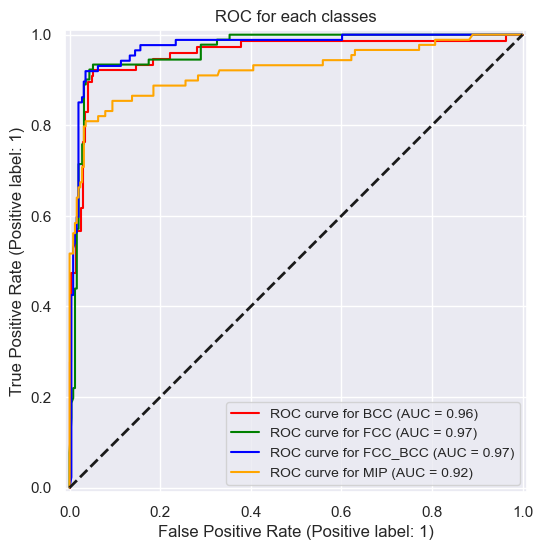

In [21]:
# PLOT ROC CURVE
fig, ax = plt.subplots(figsize=(6, 6))
colors = cycle(["red", "green", "blue", "orange"])
for class_id, color in zip(range(4), colors):
    RocCurveDisplay.from_predictions(
        y_test[:, class_id],
        pred_proba[:, class_id],
        name=f"ROC curve for {labels[class_id]}",
        color=color,
        ax=ax,
    )
ax.plot([0, 1], [0, 1], 'k--', lw=2)
ax.legend(loc='lower right', fontsize='10')
plt.title("ROC for each classes")
plt.savefig(pwd+"/figures/nn_new_roc_curve.png", dpi=600, bbox_inches="tight")

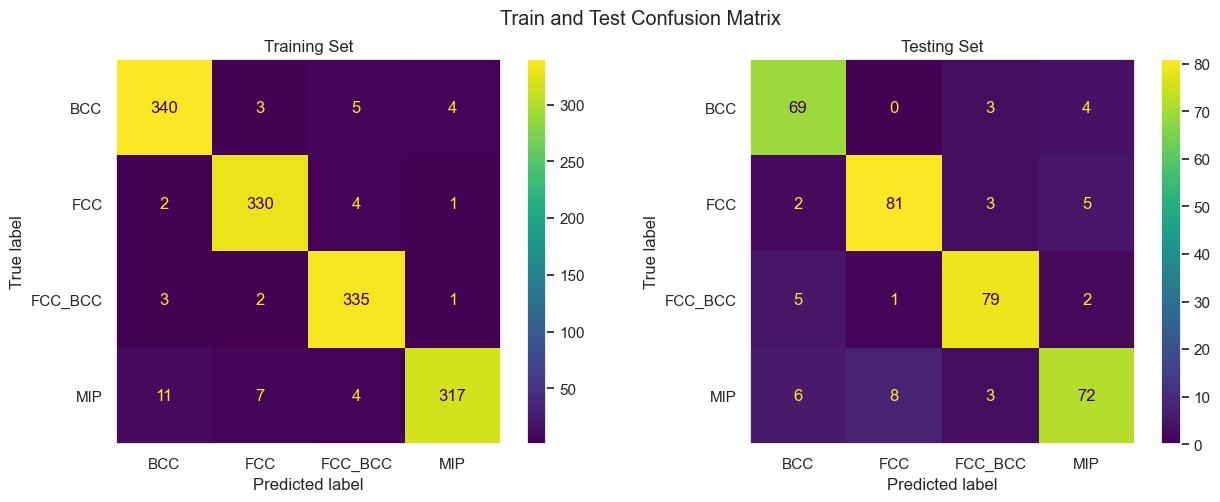

In [22]:
# CONFUSION MATRIX
cm_train = confusion_matrix(y_train_argmax, y_pred_train)
cm_test = confusion_matrix(y_test_argmax, y_pred_test)
f,(ax1, ax2) = plt.subplots(1,2, figsize = (15,5))
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=labels)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=labels)
disp_train.plot(ax = ax1)
disp_test.plot(ax = ax2)
ax1.set_title('Training Set')
ax2.set_title('Testing Set')
ax1.grid(False)
ax2.grid(False)
plt.suptitle('Train and Test Confusion Matrix')
plt.savefig(pwd+"/figures/nn_new_cf.png", dpi=600, bbox_inches="tight")

In [24]:
# 10 FOLD CROSS VALIDATION
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = []

for train_idx, test_idx in kfold.split(X, y):
    X_train_cv, y_train_cv = X.iloc[train_idx], to_categorical(y[train_idx])
    X_test_cv, y_test_cv = X.iloc[test_idx], to_categorical(y[test_idx])
    best_model = model_builder(**best_model_params['build_params'])
    best_model.fit(X_train_cv, y_train_cv, 
                   **best_model_params['fit_params'], 
                   verbose=0)
    scores = best_model.evaluate(X_test_cv, y_test_cv, verbose=0)
    cv_scores.append(scores[1]*100)

print("Cross Validation Score")
print("-"*50)
print(f"Mean Accuracy: {np.mean(cv_scores): .3f} % \nStandard Deviation: (+/-){np.std(cv_scores): .3f} %")
print("-"*50)

Cross Validation Score
--------------------------------------------------
Mean Accuracy:  86.448 % 
Standard Deviation: (+/-) 2.586 %
--------------------------------------------------
